# Music Genre prediction through Classification Modeling

##### By Abhitej Kodali, Balaji Katam, Prateek Menon and Tanmay Sinnarkar

### Instructor: Dr. Khasha Dehnad
Knowledge Discovery and Data Mining CS-513A

###### Loading the necessary libraries and functions

In [1]:
%matplotlib inline

import IPython.display as ipd
import ast, os, os.path, itertools, pydot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

os.environ["PATH"] += os.pathsep + 'D:/Anaconda3/Library/bin/graphviz'

In [2]:
class Genres:

    def __init__(self, genres_df):
        self.df = genres_df

    def create_tree(self, roots, depth=None):

        if type(roots) is not list:
            roots = [roots]
        graph = pydot.Dot(graph_type='digraph', strict=True)

        def create_node(genre_id):
            title = self.df.at[genre_id, 'title']
            ntracks = self.df.at[genre_id, '#tracks']
            #name = self.df.at[genre_id, 'title'] + '\n' + str(genre_id)
            name = '"{}\n{} / {}"'.format(title, genre_id, ntracks)
            return pydot.Node(name)

        def create_tree(root_id, node_p, depth):
            if depth == 0:
                return
            children = self.df[self.df['parent'] == root_id]
            for child in children.iterrows():
                genre_id = child[0]
                node_c = create_node(genre_id)
                graph.add_edge(pydot.Edge(node_p, node_c))
                create_tree(genre_id, node_c,
                            depth-1 if depth is not None else None)

        for root in roots:
            node_p = create_node(root)
            graph.add_node(node_p)
            create_tree(root, node_p, depth)

        return graph

    def find_roots(self):
        roots = []
        for gid, row in self.df.iterrows():
            parent = row['parent']
            title = row['title']
            if parent == 0:
                roots.append(gid)
            elif parent not in self.df.index:
                msg = '{} ({}) has parent {} which is missing'.format(
                        gid, title, parent)
                raise RuntimeError(msg)
        return roots

In [3]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

###### Loading the datasets and verifying the indices from separate files 
(F.Y.I.: loading the datasets takes time)

In [7]:
# Load tracks, genres, echonest and features.
tracks = load('E:/Knowledge Discovery & Data Mining CS 513A/Project Work/tracks.csv')
genres = load('E:/Knowledge Discovery & Data Mining CS 513A/Project Work/genres.csv')
features = load('E:/Knowledge Discovery & Data Mining CS 513A/Project Work/features.csv')
echonest = load('E:/Knowledge Discovery & Data Mining CS 513A/Project Work/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## Understanding the data

### 1. Metadata of tracks
The tracks table, a CSV file in the fma_metadata.zip archive, is composed of many colums:

1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [5]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


### 2. Genres
The genre hierarchy is stored in genres.csv and distributed in fma_metadata.zip.

In [6]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [7]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


### 3. Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [8]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Features like MFCCs are discriminant

((2000, 2), (2000,))

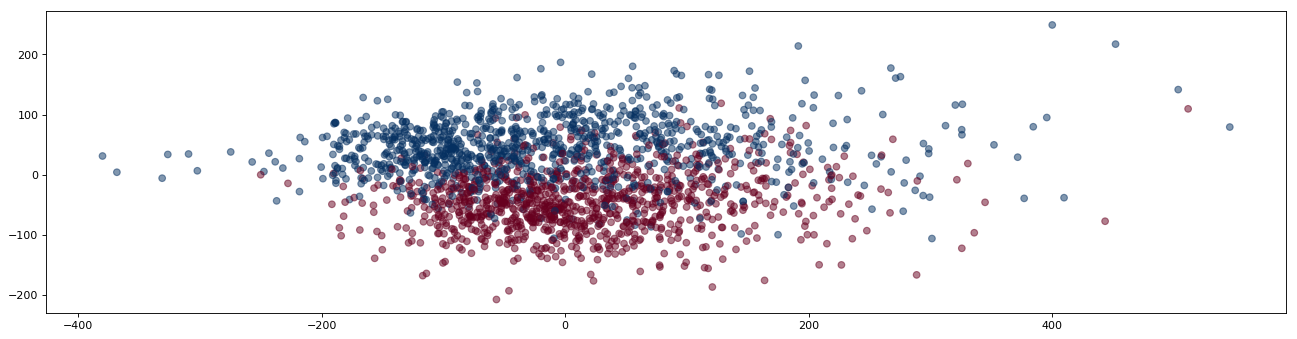

In [9]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## Analysis of the data

 #### 1. Size of the dataset

In [10]:
print('{} tracks, {} artists, {} albums, {} genres'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    sum(genres['#tracks'] > 0)))
mean_duration = tracks['track', 'duration'].mean()
print('track duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track', 'duration']) / 3600 / 24,
    mean_duration))

106574 tracks, 16341 artists, 14854 albums, 161 genres
track duration: 343 days total, 278 seconds average


In [11]:
for subset in tracks['set', 'subset'].unique():
    indicator = tracks['set', 'subset'] <= subset
    print('{:6} {:6} tracks  {:.1f} days'.format(
        subset, sum(indicator), sum(indicator) * 30 / 3600 / 24))

small    8000 tracks  2.8 days
medium  25000 tracks  8.7 days
large  106574 tracks  37.0 days


#### 2. Number of tracks per genre

(1, 38154)

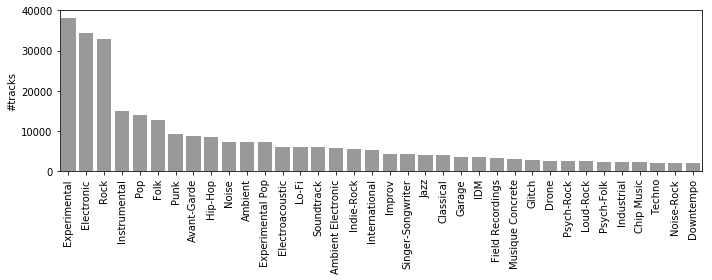

In [12]:
# Number of tracks per genre (full).
d = genres[genres['#tracks'] > 2000].sort_values('#tracks', ascending=False)
plt.figure(figsize=(10, 4))
p = sns.barplot('title', '#tracks', data=d, color='k', alpha=0.4)
p.set_xlabel('')
p.set_ylabel('#tracks')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('genre_distribution.pdf')

genres.loc[genres['#tracks'] > 0, '#tracks'].min(), genres['#tracks'].max()

#### 3. Number of tracks per top-level genre (medium)

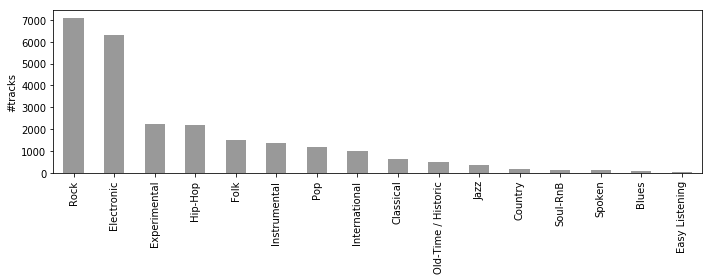

In [13]:
# Number of tracks per top-level genre (medium).
d = tracks[tracks['set', 'subset'] <= 'medium']
d = d['track', 'genre_top'].value_counts()
plt.figure(figsize=(10, 4))
d.plot.bar(color='k', alpha=0.4)
plt.ylabel('#tracks')
plt.tight_layout()
plt.savefig('genre_top_distribution.pdf')

#### 4. Genre hierarchy

* As genres have parent genres, we can plot a tree using the [DOT] language.
* Save the full genre tree as a PDF.

Todo:
* Color nodes according to FMA genre color.
* Better looking tree.

[DOT]: https://en.wikipedia.org/wiki/DOT_(graph_description_language)

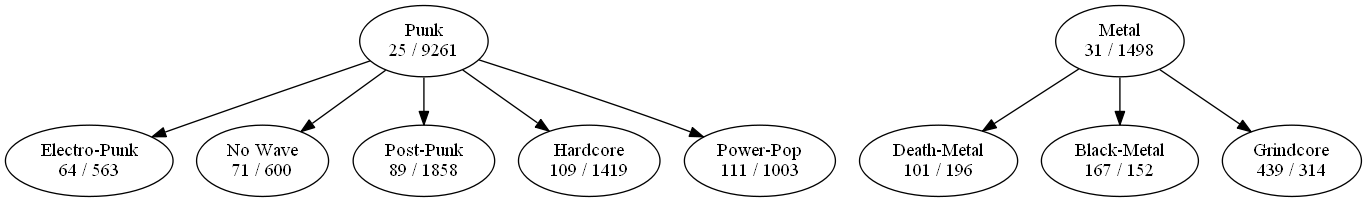

In [14]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Anaconda3/Library/bin/graphviz'

g = Genres(genres)
graph = g.create_tree([25, 31], 1)
ipd.Image(graph.create_png())

In [15]:
graph = g.create_tree(14)
graph.write_pdf('genre_hierarchy.pdf');

roots = g.find_roots()
print('{} roots'.format(len(roots)))
graph = g.create_tree(roots)
graph.write_png('genre_hierarchy.png');

16 roots


#### 5. Cross-appearance

Todo:
* Group rows and columns for better identification of related genres.

In [16]:
enc = MultiLabelBinarizer()
g_id = [in]
genres_indicator = enc.fit_transform(tracks['track', 'genres'])
genres_names = enc.classes_
genres_names = genres.loc[enc.classes_, 'title'].values
cross_correlation = genres_indicator.T @ genres_indicator

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


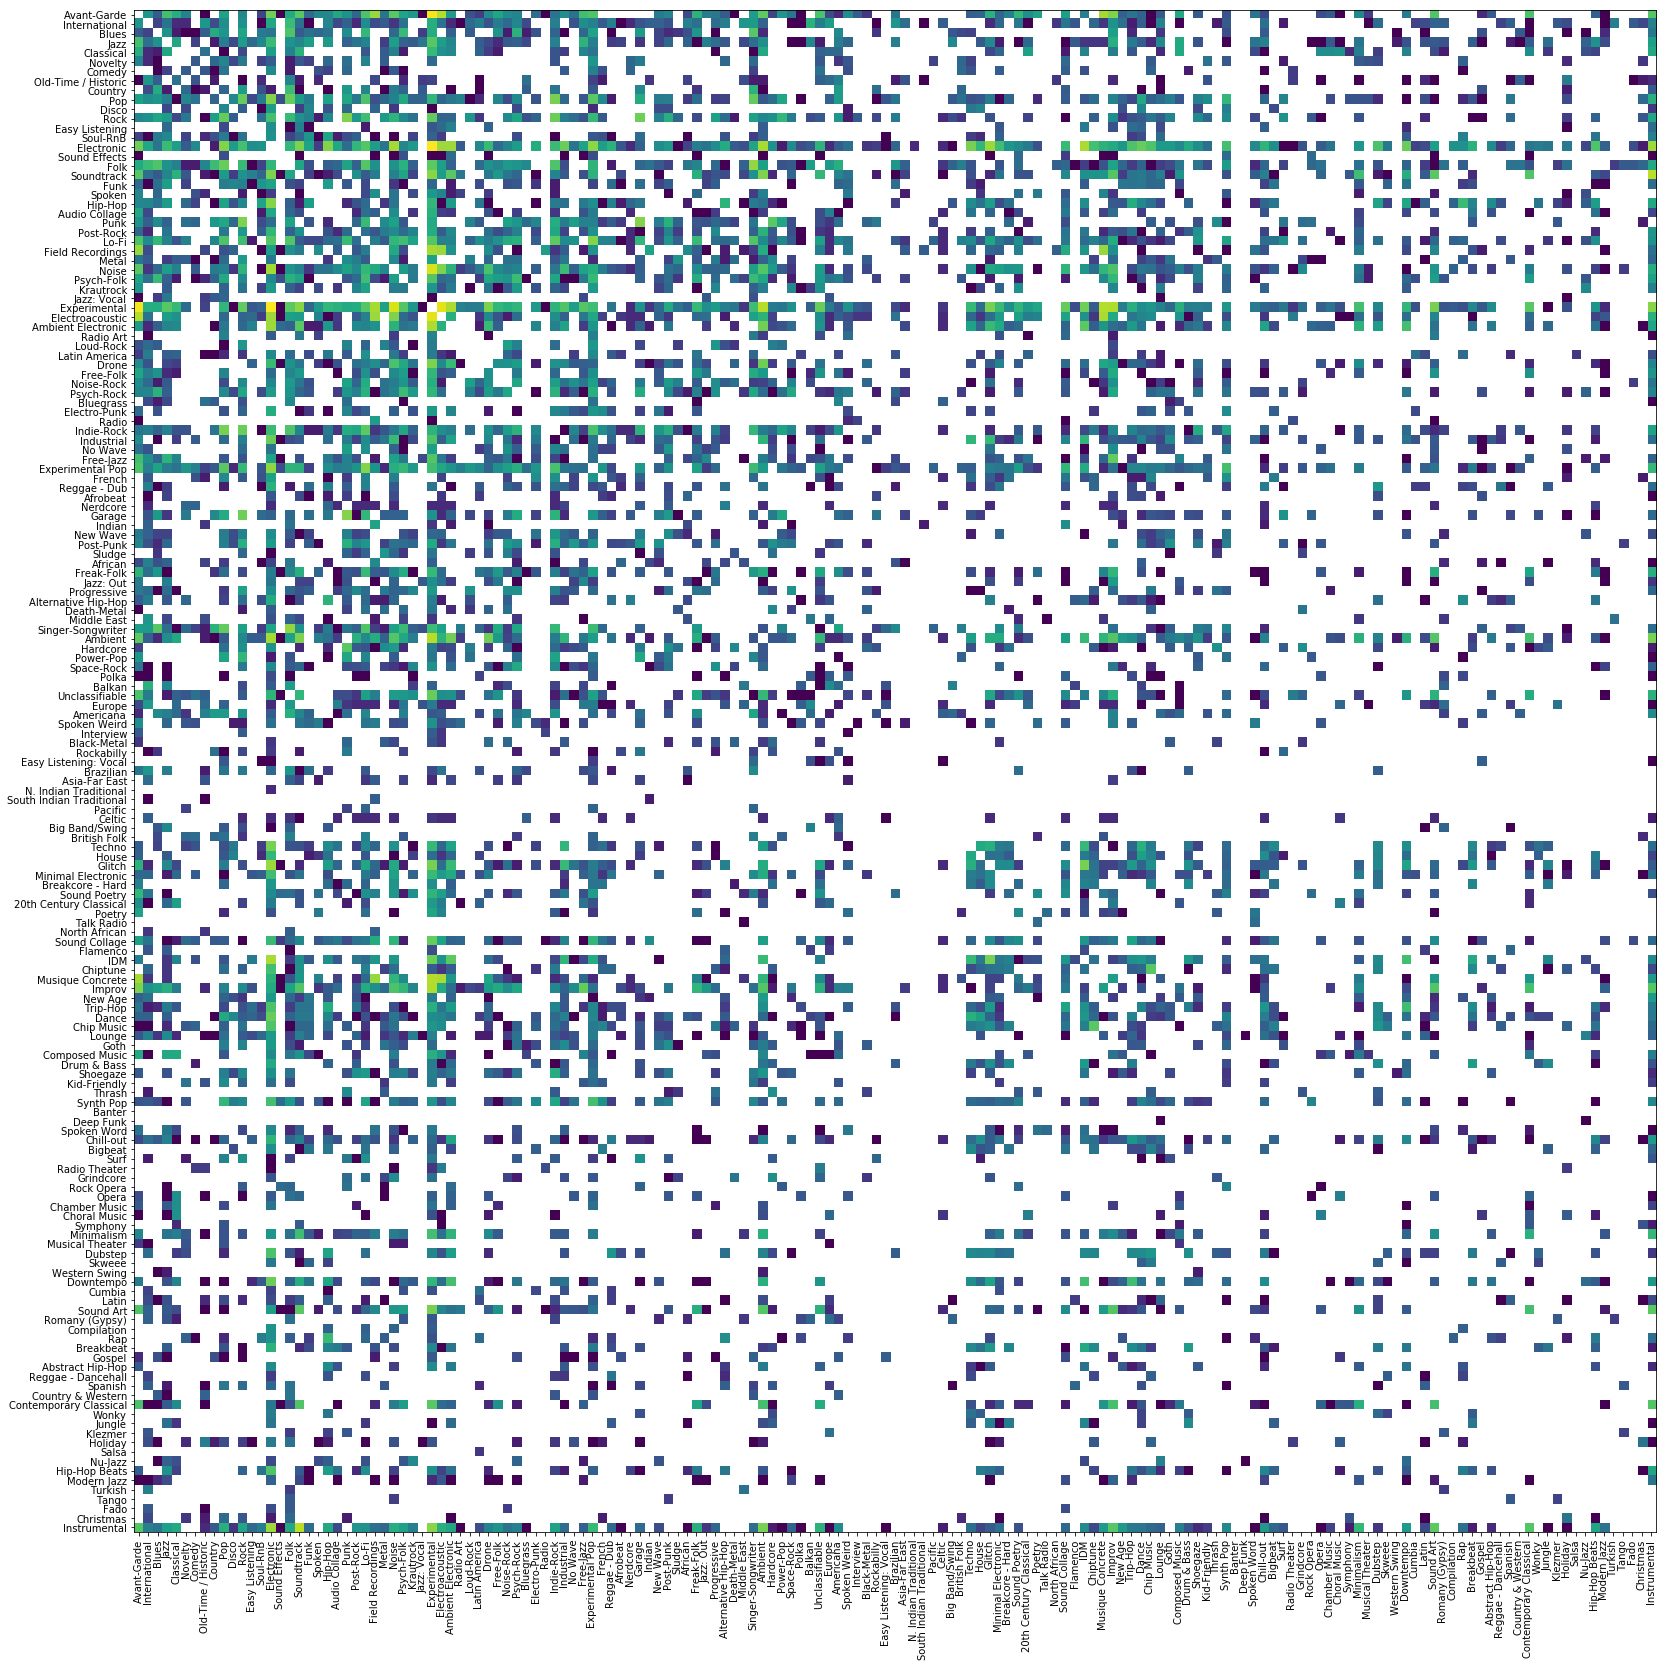

In [82]:
np.fill_diagonal(cross_correlation, 0)

plt.figure(figsize=(28, 28))
plt.imshow(np.log(cross_correlation))
plt.yticks(range(len(genres_names)), genres_names);
plt.xticks(range(len(genres_names)), genres_names, rotation=90);
plt.savefig('genre_crossappearance.png')

## Modeling the data

#### 1. From Features Table, following is derived

In [85]:
medium = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]
X_train = features.loc[medium & train, 'mfcc']
X_test = features.loc[medium & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

GENRES = tracks['track','genre_top'].dropna().unique()

19922 training examples, 2573 testing examples
140 features, 16 classes


#### 2. Defining Confusion matrix function

In [80]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
    # plt.figure(figsize=(16,16))
    plt.imshow(np.log(cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    
    thresh = cm.max() / 5.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 3. Running the models

In [20]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 2.12472231e-01, -1.21575759e-01,  1.59221131e-02, ...,
         1.54875684e-01, -4.83327352e-02,  4.18859095e-01],
       [ 2.68300051e+00,  7.53850874e-01,  1.75008045e+00, ...,
        -3.90599650e-01, -6.68296344e-01, -6.28603663e-01],
       [-2.61655770e-01, -1.27442969e-01, -1.19880870e-03, ...,
        -8.99907309e-01, -4.09880552e-01, -1.04398104e+00],
       ...,
       [-4.66801248e-01, -5.24603794e-01, -9.51418934e-02, ...,
         8.23938048e-01,  2.48148052e+00,  1.74553805e+00],
       [-4.06846860e-01, -2.21500978e-01,  2.92898850e-02, ...,
        -3.67499399e-01,  2.93762445e-01,  4.39451865e-01],
       [-4.54966022e-01, -7.61709511e-01,  2.04847206e-01, ...,
         1.66878453e-01, -1.60391351e-02,  1.00648067e+00]])

###### 3.1 Decision Trees

#####################################################################################
Accuracy for Decision Tree: 39.06%
Confusion matrix, without normalization
[[  0   0   0   0   0   1   0   1   3   1   1   0   0   1   0   0]
 [  0  20   0   0  10   9   4   1   4   4   1   0   4   3   0   2]
 [  0   1   1   0   2   0   0   3   0   0   0   0   3   8   0   0]
 [  0   1   0   0   0   1   0   0   2   0   0   0   0   1   0   1]
 [  0   5   2   0 296  54  15  76  28  39  19   0  24  68   4   2]
 [  4   7   1   0  41  33  10  13  28  11   4   1  17  54   1   0]
 [  0   1   1   0  24  17  25   4  13  12   0   2  15  38   0   0]
 [  3   0   1   0  80  11   2  77   4  11   6   0   5  20   0   0]
 [  2  15   2   1  29  29  18   2  21  10   4   2  12  24   0   3]
 [  1   2   1   0  14   5   9  12   7  17   2   0   6  26   0   0]
 [  0   6   0   0   7   0   4   0   5   0   7   1   0   7   2   0]
 [  0   0   0   0   0   1   0   0   1   1   0  46   1   1   0   0]
 [  0   0   2   0  37   9   6  13  

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


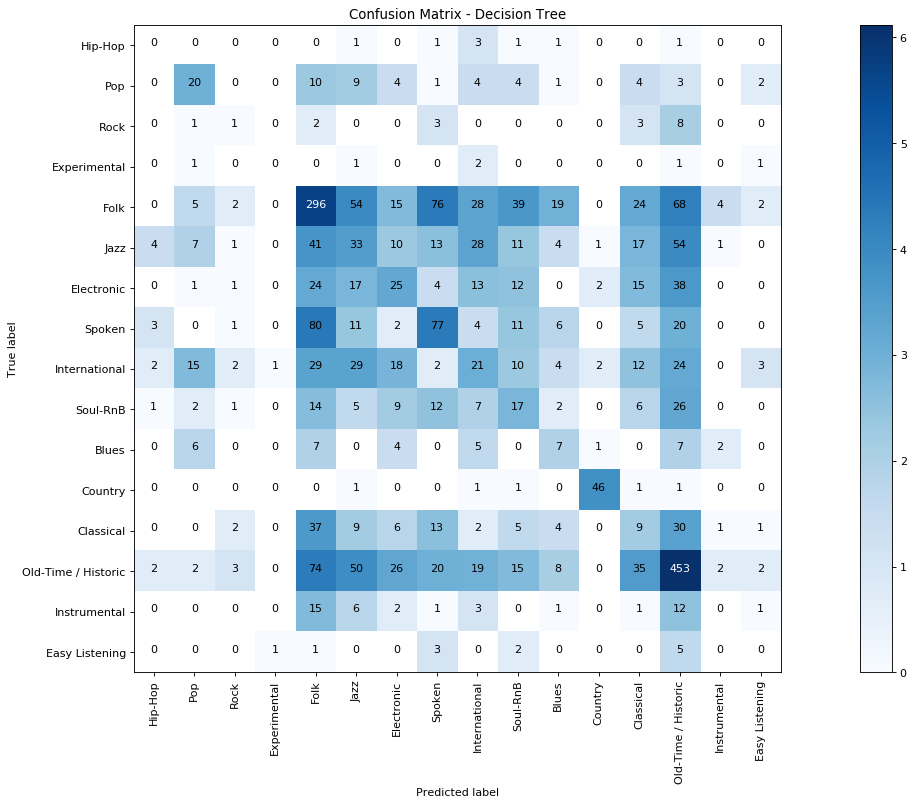

In [86]:
############# Decision Tree ##############
print("#####################################################################################")

# Train the model
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

# Predict the labels for test data
y_combo_predicted = dt_classifier.predict(X_test)

#Accuracy Calculation
score1=dt_classifier.score(X_test, y_test)
print('Accuracy for Decision Tree: {:.2%}'.format(score1))

# Making the Confusion Matrix
cm1 = confusion_matrix(y_test, y_combo_predicted)
plot_confusion_matrix(cm=cm1,classes=GENRES,title='Confusion Matrix - Decision Tree')
plt.savefig('cm_dt.png')

###### 3.2 Random Forest

#####################################################################################
Accuracy for Random Forest: 52.66%
Confusion matrix, without normalization
[[  0   0   0   0   2   0   1   1   0   1   0   0   0   3   0   0]
 [  0  35   0   0   3   6   3   2   6   2   0   2   1   2   0   0]
 [  0   0   0   0   6   0   0   5   0   0   0   0   0   7   0   0]
 [  0   1   0   0   2   1   0   0   2   0   0   0   0   0   0   0]
 [  0   4   1   0 523  17   8  19  10   5   1   0   3  41   0   0]
 [  0  11   0   0  75  40  12   9  12   6   1   0   4  55   0   0]
 [  0   4   1   0  26  18  27   1   4  13   0   2   2  54   0   0]
 [  0   1   0   0 117   8   0  79   1   1   0   0   1  12   0   0]
 [  0  19   1   0  41  30  34   0  21   2   0   5   0  21   0   0]
 [  0   1   2   0  30   5  28   9   1   5   0   0   1  20   0   0]
 [  0   2   0   0  15   6   6   0   3   1   2   0   1   3   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0  50   0   0   0   0]
 [  0   0   0   0  64   7   8  11  

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


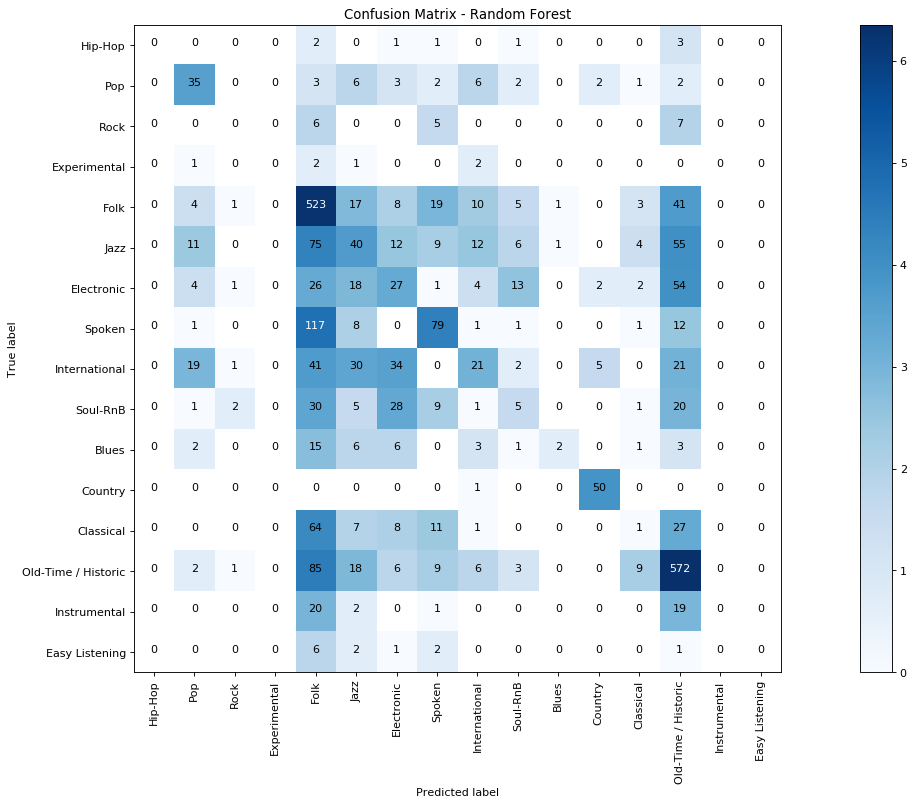

In [87]:
####### Random Forest #############################
print("#####################################################################################")

# Train the model
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
classifier1 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier1.fit(X_train, y_train)

# Predicting the Test set results
rf_pred = classifier1.predict(X_test)

#Accuracy Calculation
score2 = classifier1.score(X_test, y_test)
print('Accuracy for Random Forest: {:.2%}'.format(score2))

# Making the Confusion Matrix
cm2 = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix(cm=cm2,classes=GENRES,title='Confusion Matrix - Random Forest')
plt.savefig('cm_rf.png')

###### 3.3 KNN

#####################################################################################
Accuracy for KNN: 56.90%
Confusion matrix, without normalization
[[  0   0   0   0   2   0   0   1   1   1   0   0   1   2   0   0]
 [  0  40   0   0   1   2   0   1   1   9   0   5   3   0   0   0]
 [  0   0   0   0   1   0   1  12   0   0   0   0   0   4   0   0]
 [  0   0   0   0   2   0   0   0   4   0   0   0   0   0   0   0]
 [  0   8   0   0 485   4   6  59  14   5   0   0   1  50   0   0]
 [  0  11   1   0  68  17  15   9  23   4   1   0   1  75   0   0]
 [  0  11   2   0   8   3  39   0   5  16   1   1   7  59   0   0]
 [  0   0   0   0  69   0   0 135   1   4   0   0   1  10   0   0]
 [  0  17   0   0  25  11  50   2  38   2   0   1   1  27   0   0]
 [  0   2   7   0  14   0  20  13   0  28   0   0   1  17   0   0]
 [  0   3   0   0  10   3   3   0   3   3  11   0   0   3   0   0]
 [  0   1   0   0   0   1   0   0   0   0   0  49   0   0   0   0]
 [  0   0   1   0  47   2  13  17   1   6   0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


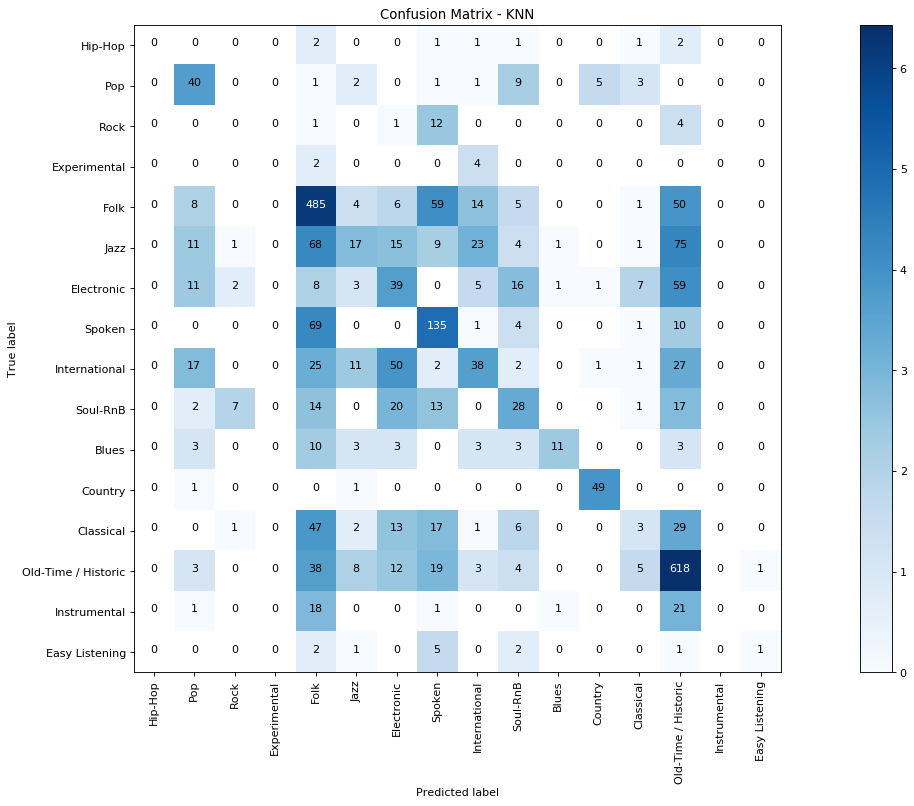

In [88]:
############### knn ################################
print("#####################################################################################")

# Train the model
classifier_knn = KNeighborsClassifier(n_neighbors = 17, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train, y_train)

# Predicting the Test set results
knn_pred = classifier_knn.predict(X_test)

#Accuracy Calculation
score3 = classifier_knn.score(X_test, y_test)
print('Accuracy for KNN: {:.2%}'.format(score3))

# Making the Confusion Matrix
cm3 = confusion_matrix(y_test, knn_pred)
plot_confusion_matrix(cm=cm3,classes=GENRES,title='Confusion Matrix - KNN')
plt.savefig('cm_knn.png')

###### 3.4 Logistic Regression

#####################################################################################
Accuracy for Logistic: 57.36%
Confusion matrix, without normalization
[[  0   0   0   0   1   1   0   0   1   0   0   0   0   5   0   0]
 [  0  53   0   0   1   1   0   0   5   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   2   3   0   1   0   0   0  10   0   0]
 [  0   0   0   0   0   1   0   0   4   0   0   0   0   1   0   0]
 [  0   3   0   0 508  23   6  29   7   3   0   0   1  52   0   0]
 [  0   7   0   0  66  35  16   7  14   8   3   1   1  67   0   0]
 [  0   0   0   0  18  14  38   0   3  12   1   4   2  59   1   0]
 [  0   0   0   0  75   0   1 124   0   4   0   0   0  15   0   1]
 [  1  10   1   0  32   7  42   1  24   1   2   1   0  52   0   0]
 [  0   2   0   0  29   3  16   4   0  19   1   0   2  25   0   1]
 [  0   4   0   0  12   5   3   0   0   0  12   0   0   3   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  50   0   0   0   1]
 [  0   0   0   0  69   2   8   6   1   

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


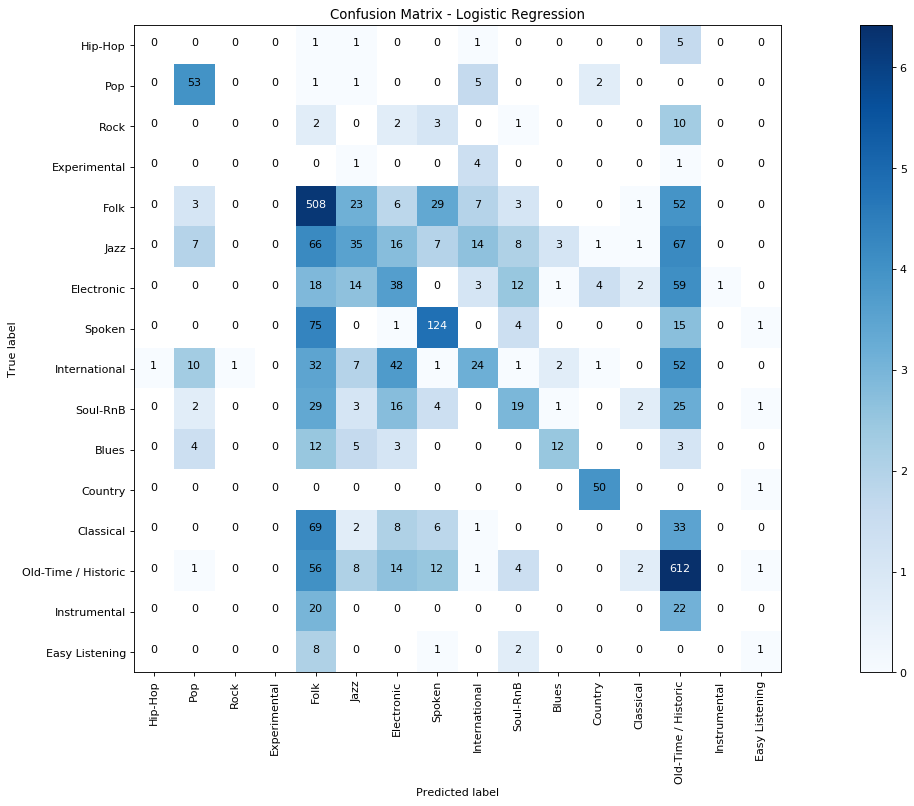

In [89]:
######## Logistic ######################
print("#####################################################################################")

# Train the model
classifier_log = LogisticRegression(random_state = 0)
classifier_log.fit(X_train, y_train)

# Predicting the Test set results
lr_pred = classifier_log.predict(X_test)

#Accuracy Calculation
score4 = classifier_log.score(X_test, y_test)
print('Accuracy for Logistic: {:.2%}'.format(score4))

# Making the Confusion Matrix
cm4 = confusion_matrix(y_test, lr_pred)
plot_confusion_matrix(cm=cm4,classes=GENRES,title='Confusion Matrix - Logistic Regression')
plt.savefig('cm_lr.png')

###### 3.5 Naive Bayes

#####################################################################################
Accuracy for Naive Bayes: 42.01%
Confusion matrix, without normalization
[[  1   0   0   0   0   0   1   1   1   0   1   0   0   1   1   1]
 [  0  32   0   0   0   4   0   0   9  11   0   5   0   0   0   1]
 [  0   0   5   0   2   0   0   6   0   0   0   0   1   2   2   0]
 [  0   1   0   0   0   0   0   0   5   0   0   0   0   0   0   0]
 [  2  10  11   6 195  21   8 203  12  21  11   1  12  51  54  14]
 [  3  10  13   0  20  31  16  10  34  14  11   3   4  43   7   6]
 [  3   8  11   0   5   4  45   0  14   6   7   6   9  33   0   1]
 [  0   0   7  13  22   2   0 140   2   3   1   0   0  16   9   5]
 [  1  22   4   0   5  12  54   5  42   6   4  12   2   3   0   2]
 [  2   2  33   2   5   2  17  13   0   4   1   0   3   8   8   2]
 [  0   2   3   2   2   0   4   0   4   0  14   0   0   1   7   0]
 [  0   0   0   0   0   2   0   0   0   0   0  49   0   0   0   0]
 [  5   0  24   1   8   1   7  34   3

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


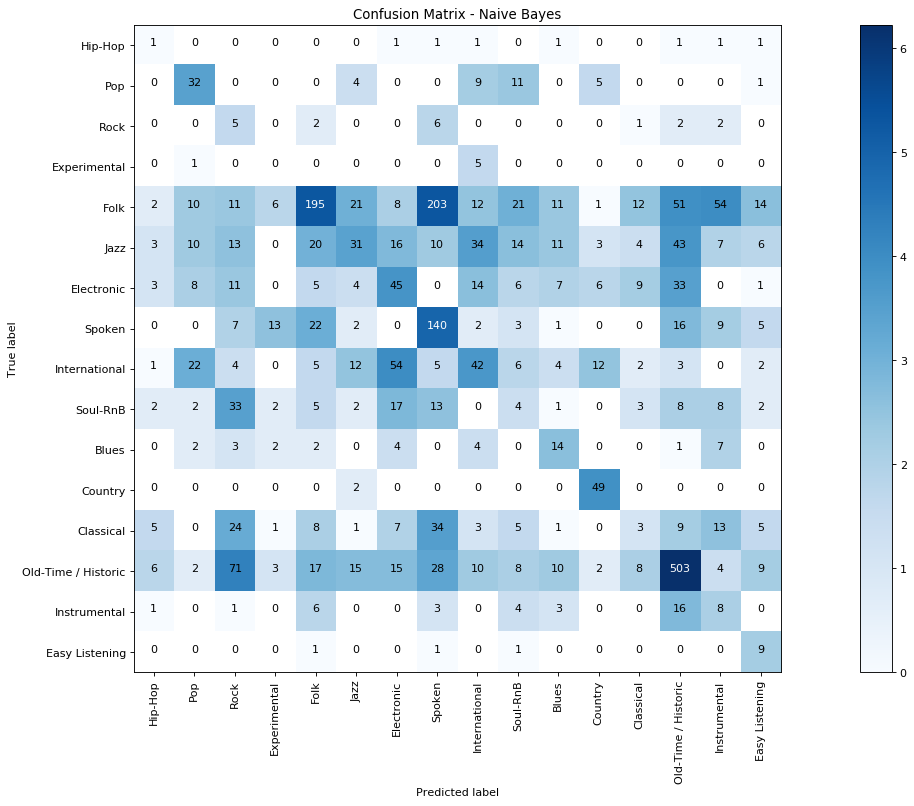

In [90]:
######### Naive Bayes ############
print("#####################################################################################")

# Train the model
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

# Predicting the Test set results
nb_pred = classifier_nb.predict(X_test)

#Accuracy Calculation
score5 = classifier_nb.score(X_test, y_test)
print('Accuracy for Naive Bayes: {:.2%}'.format(score5))

# Making the Confusion Matrix
cm5 = confusion_matrix(y_test, nb_pred)
plot_confusion_matrix(cm=cm5,classes=GENRES,title='Confusion Matrix - Naive Bayes')
plt.savefig('cm_nb.png')

###### 3.6 Support Vector Machine

#####################################################################################
Accuracy for Kernel SVM: 61.25%
Confusion matrix, without normalization
[[  0   0   0   0   2   1   0   1   1   0   0   0   0   3   0   0]
 [  0  54   0   0   0   4   0   0   2   1   0   1   0   0   0   0]
 [  0   0   0   0   2   0   1   9   0   0   0   0   0   6   0   0]
 [  0   0   0   0   1   1   0   0   3   0   0   0   0   1   0   0]
 [  0   2   0   0 534  28   2  25  12   2   1   0   1  25   0   0]
 [  0   3   0   0  73  62   7   4  19   3   1   0   1  52   0   0]
 [  0   0   0   0  11  29  41   0   5  16   1   2   0  47   0   0]
 [  0   0   0   0  76   8   0 129   1   1   0   0   0   5   0   0]
 [  0   4   0   0  32  20  37   1  43   1   0   0   0  36   0   0]
 [  0   2   0   0  22   4  16   7   0  33   1   0   2  15   0   0]
 [  0   4   0   0   7   6   2   0   2   0  15   0   0   3   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0  49   0   0   0   0]
 [  0   0   0   0  62   2   5   5   1 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


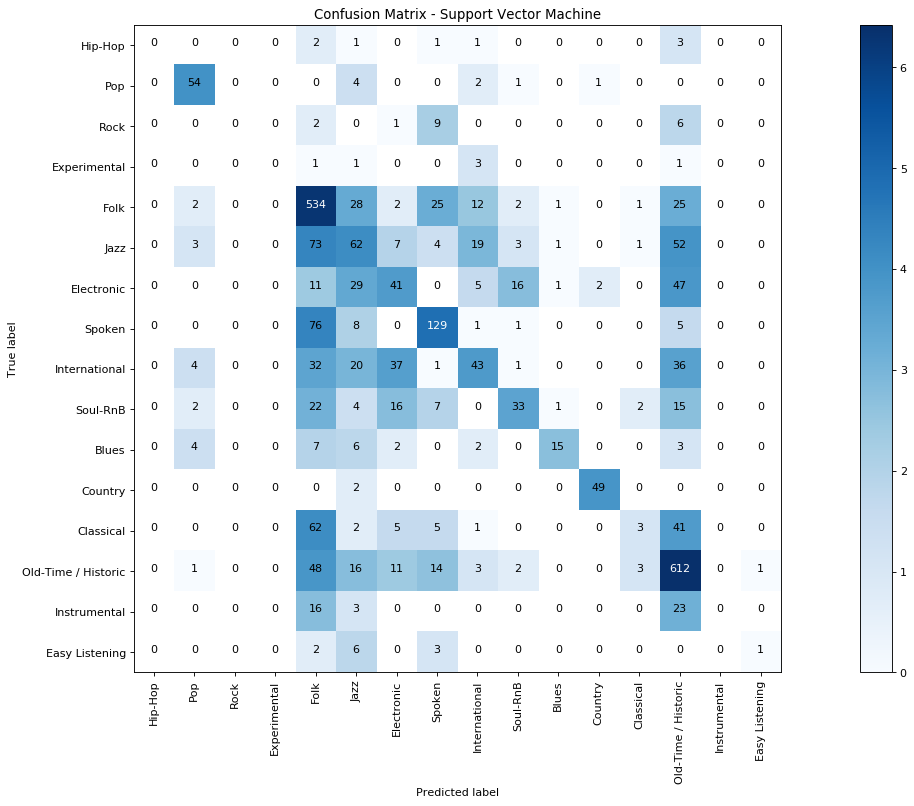

In [91]:
######### Kernel SVM ############
print("#####################################################################################")

# Train the model
classifier_svm = SVC(kernel = 'rbf', random_state = 0)
classifier_svm.fit(X_train, y_train)

# Predicting the Test set results
ksvm_pred = classifier_svm.predict(X_test)

#Accuracy Calculation
score6 = classifier_svm.score(X_test, y_test)
print('Accuracy for Kernel SVM: {:.2%}'.format(score6))

# Making the Confusion Matrix
cm6 = confusion_matrix(y_test, ksvm_pred)
plot_confusion_matrix(cm=cm6,classes=GENRES,title='Confusion Matrix - Support Vector Machine')
plt.savefig('cm_svm.png')

#### 4. KNN: Accuracy vs K values

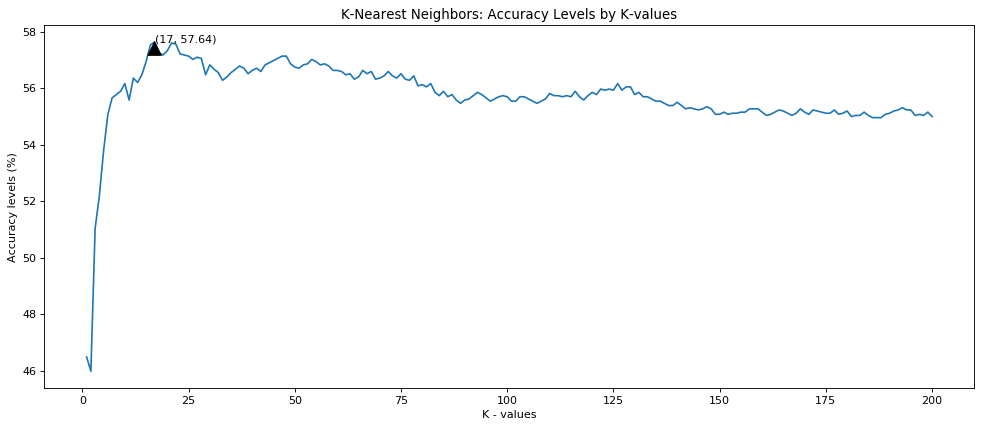

In [59]:
d = []
r = []
k_max = 0
acc_max = 0
for K in range(200):
    K_value = K+1
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    neigh.fit(X_train, y_train) 
    y_pred = neigh.predict(X_test)
    acc = accuracy_score(y_test,y_pred)*100
    #print("Accuracy is ", acc,"% for K-Value:",K_value)
    if acc > acc_max:
        acc_max = acc
        k_max = K_value
    d.append(acc)
    r.append(K_value)

fig=plt.figure(figsize=(15, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
plt.title("K-Nearest Neighbors: Accuracy Levels by K-values")
plt.ylabel("Accuracy levels (%)")
plt.xlabel("K - values")
ax.annotate((k_max,round(acc_max,2)), xy=(k_max, acc_max), xytext=(k_max, acc_max),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(r,d)
plt.show()
plt.savefig('KNN_accuracy_k_values.png')